# Comparative Analysis with TF-IDF Weightings

Libraries used:
* pandas
* re
* numpy
* pandas
* re
* numpy
* pickle
* gensim.models
* os
* gensim.downloader as api
* matplotlib.pyplot as plt
* nltk
* seaborn
* nltk.tokenize: word_tokenize
- sklearn.preprocessing: normalize
- sklearn.feature_extraction.text: CountVectorizer
- itertools: chain
- nltk.probability *
- gensim.corpora: Dictionary
- gensim.models: TfidfModel
- gensim.matutils: sparse2full
- sklearn.model_selection: train_test_split
- sklearn.linear_model: LogisticRegression
- sklearn.model_selection: KFold
- sklearn.metrics: confusion_matrix, precision_score, recall_score, f1_score


## Importing libraries 

In [1]:
import pandas as pd
import re
import numpy as np
import pickle
import gensim.models
import os
import gensim.downloader as api
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
from nltk.probability import *
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import sparse2full
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

### Creating Data Frame

In [2]:
# Load the tokenized articles from Task 1
with open('tokenized_articles.pkl', 'rb') as f:
    tokenized_articles = pickle.load(f)
    
dir_path = ["./data/Accounting_Finance/", "./data/Engineering/", "./data/Healthcare_Nursing/", "./data/Sales/"]
#  # list to store the article ID, the text and the categories derived from the directory structure
article_ids = []
article_txts = [] 
categories = []

for path in dir_path:
     # Extracting the category from the directory path
    category = path.split('/')[-2]
    # we want to load articles in ascending order of their file names
    for filename in sorted(os.listdir(path)): 
         # we only look at the txt file
        if filename.endswith(".txt"):
            # split the file name with '.', 
            # so the first part is the article ID, and 2nd part is 'txt'
            # we then take the first part and store it
            article_ids.append(filename.split(".")[0]) 
            # open the txt file
            with open(os.path.join(path, filename), "r", encoding='unicode_escape') as f: 
                # read the file into a string, and append it to the article_txts list
                article_txts.append(f.read()) 
                 # append the category to the categories list
            categories.append(category)

# Create a DataFrame with article_id, text, and category
df = pd.DataFrame({
    'article_id': article_ids,
    'text': article_txts,
    'category': categories
})

In [3]:
df.head()

,article_id,text,category
0,Job_00232,Title: FP&A Blue Chip\nWebindex: 68802053\nCo...,Accounting_Finance
1,Job_00233,Title: Part time Management Accountant\nWebind...,Accounting_Finance
2,Job_00234,Title: IFA EMPLOYED\nWebindex: 71356489\nComp...,Accounting_Finance
3,Job_00235,Title: Finance Manager\nWebindex: 69073629\nCo...,Accounting_Finance
4,Job_00236,Title: Management Accountant\nWebindex: 706566...,Accounting_Finance


### Adding Title & Company

In [4]:
def extractTitle(article):
    # Matching the pattern "Title: " and then any character after it until the newline character
    match = re.search(r"Title: (.+?)\n", article)  
    if match:
        # extract the title text from the article
        title_text = match.group(1)
        return title_text
    else:
        return None

def extractCompany(article):
    # Matching the pattern "Title: " and then any character after it until the newline character
    match = re.search(r"Company: (.+?)\n", article)  
    if match:
        # extract the title text from the article
        title_text = match.group(1)
        return title_text
    else:
        return None

def extractDescription(article):
    # Matching the pattern "Title: " and then any character after it until the newline character
    match = re.search(r"Description: (.+)", article)  
    if match:
        # extract the title text from the article
        title_text = match.group(1)
        return title_text
    else:
        return None
# Assigning the extracted title and company to the dataframe
df['title'] = df.text.apply(extractTitle)
df['title'] = df['title'].str.encode('ascii', 'ignore').str.decode('utf-8')

# Assigning the extracted title, description, title+description and company to the dataframe
df['company'] = df.text.apply(extractCompany)
df['description'] = df.text.apply(extractDescription)
df['title_description'] = df['title'] + ' ' + df['description']


df.head()

,article_id,text,category,title,company,description,title_description
0,Job_00232,Title: FP&A Blue Chip\nWebindex: 68802053\nCo...,Accounting_Finance,FP&A Blue Chip,Hays Senior Finance,A market leading retail business is going thro...,FP&A Blue Chip A market leading retail busine...
1,Job_00233,Title: Part time Management Accountant\nWebind...,Accounting_Finance,Part time Management Accountant,FS2 UK Ltd,You will be responsible for the efficient runn...,Part time Management Accountant You will be re...
2,Job_00234,Title: IFA EMPLOYED\nWebindex: 71356489\nComp...,Accounting_Finance,IFA EMPLOYED,Clark James Ltd,Role The purpose of the role is to provide adv...,IFA EMPLOYED Role The purpose of the role is ...
3,Job_00235,Title: Finance Manager\nWebindex: 69073629\nCo...,Accounting_Finance,Finance Manager,Accountancy Action Ltd,"Excellent opportunity to join our client, an e...",Finance Manager Excellent opportunity to join ...
4,Job_00236,Title: Management Accountant\nWebindex: 706566...,Accounting_Finance,Management Accountant,Alexander Lloyd,Our client offers a interesting opportunity fo...,Management Accountant Our client offers a inte...


In [5]:
df.shape

(776, 7)

## Task 2. Generating Feature Representations for Job Advertisement Descriptions

In [6]:
# Creating a list of all the words in the articles
word_list = list(chain.from_iterable(tokenized_articles))
# Creating a set of all the words in the articles
vocab = set(word_list)

### Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

In [7]:
# Creating a dictionary of all the words in the articles
count_vec = CountVectorizer(analyzer="word", vocabulary=vocab)
# Creating a count matrix of all the words in the articles
count_matrix = count_vec.fit_transform([' '.join(article) for article in tokenized_articles])

with open('count_vectors.txt', 'w') as f:
    for vecindex, row in enumerate(count_matrix):
        # Start the line with # and webindex (assuming webindex is just idx for simplicity)
        line = f"#{vecindex},"
        
        # Get non-zero indices and their values from the row
        non_zero_indices = row.nonzero()[1]
        non_zero_values = row.data
        
        # Append word_integer_index:word_freq pairs to the line
        line += ','.join([f"{index}:{int(value)}" for index, value in zip(non_zero_indices, non_zero_values)])
        
        # Write the line to the file
        f.write(line + '\n')

# Normalizing Word2Vec Embeddings

In [8]:
# Creating a dictionary of all the words matching tokenized_articles
word2v = gensim.models.Word2Vec(sentences=tokenized_articles,vector_size=50)

# Creating a dictionary of all the words matching tokenized_articles
word2v_wv = word2v.wv

In [9]:
def docvecs(embeddings, docs):
    """
    Generates document vectors by summing up the embeddings
    of the words in the document and normalizing the vector.
    (Similar to one-hot encoding)

    Args:
        embeddings: Word embedding model (e.g. Word2Vec)
        docs: List of tokenized documents

    Returns:
        _type_: _description_
    """
    # Create a matrix of zeros with the same shape as token_dictionary
    vecs = np.zeros((len(docs), embeddings.vector_size))
    # Fill in the embeddings for the words that are present in the Word2Vec model
    for i, doc in enumerate(docs):
        valid_keys = [term for term in doc if term in embeddings.key_to_index]
        # if valid_keys is not empty
        if valid_keys:  
            # get the embedding vector of the word and store it inside index of the matrix
            docvec = np.vstack([embeddings[term] for term in valid_keys])
            # sum the vectors of all the words in the document
            docvec = np.sum(docvec, axis=0)
            # normalize the vector
            vecs[i,:] = docvec
    return vecs
# Compute the document vectors
word2vDesc = docvecs(word2v_wv, df.text)

# TF-IDF Weighted

In [10]:
def generate_tfidf_representation(tokenized_articles):
    """
    Generate the TF-IDF representation for tokenized articles.
    
    Parameters:
    - tokenized_articles: List of tokenized articles.
    
    Returns:
    - corpus_tfidf: TF-IDF representation of the articles.
    - document_dict: Gensim dictionary of the documents.
    - corpus_bow: Bag-of-words representation of the documents.
    - token_dict: Dictionary where each unique word is assigned a unique ID.
    """
    
    # Creating a list of all the words in the articles
    word_list = list(chain.from_iterable(tokenized_articles))

    # Creating a set of all the words in the articles
    vocab = set(word_list)

    # Create a dictionary where each unique word is assigned a unique ID.
    token_dict = {word_id: word for word_id, word in enumerate(vocab)}

    # Create a Dictionary Object
    document_dict = Dictionary(tokenized_articles)

    # Convert Documents to BoW Format
    corpus_bow = [document_dict.doc2bow(doc) for doc in tokenized_articles]

    # Train a TfidfModel
    # Use dictionary as id2word
    tfidf_model = TfidfModel(corpus_bow, id2word=document_dict)  

    # Apply the TF-IDF Model to the BoW Corpus
    corpus_tfidf = tfidf_model[corpus_bow]
    
    return corpus_tfidf, document_dict, corpus_bow, token_dict

# Usage
corpus_tfidf, document_dict, corpus_bow, token_dict = generate_tfidf_representation(tokenized_articles)
print(corpus_tfidf[0])


[(0, 0.0946443912140291), (1, 0.1039385874903489), (2, 0.10131907304920566), (3, 0.10837732596379489), (4, 0.0909237648477777), (5, 0.04830094342288568), (6, 0.1437015842324428), (7, 0.21364094194624395), (8, 0.08538445407690888), (9, 0.1317279018680523), (10, 0.06301006667795675), (11, 0.08922946423527785), (12, 0.1283363625477385), (13, 0.05100569167989043), (14, 0.04223525873397134), (15, 0.1039385874903489), (16, 0.1200526139159236), (17, 0.1892887824280582), (18, 0.15997068708381085), (19, 0.14001165049986725), (20, 0.10837732596379489), (21, 0.06171570031536512), (22, 0.15997068708381085), (23, 0.08686143438917834), (24, 0.12255808938385004), (25, 0.12255808938385004), (26, 0.09542253629011885), (27, 0.08686143438917834), (28, 0.11561387544247763), (29, 0.07569580227459034), (30, 0.06203387817265146), (31, 0.09780589459148725), (32, 0.15168693845199593), (33, 0.04389058819777094), (34, 0.09180982870016503), (35, 0.06402051432246164), (36, 0.09670203801166617), (37, 0.072304262954

In [11]:
def compute_tfidf_weighted_embeddings(token_dict, word2v_wv, document_dict, corpus_bow):
    """
    Compute the TF-IDF weighted embeddings for arguments
    
    Parameters:
    - token_dict: Dictionary of tokens
    - word2v_wv: Word2Vec model
    - document_dict: Gensim dictionary of the documents
    - corpus_bow: Bag-of-words representation of the documents
    
    Returns:
    - tfidf_docs_emb: TF-IDF weighted embeddings for the documents.
    """
    
    # Create a matrix of zeros with the same shape as token_dictionary
    word_emb_vecs = np.zeros((len(token_dict), 50))

    # Fill in the embeddings for the words that are present in the Word2Vec model
    for word_id, word in token_dict.items():
        if word in word2v_wv.key_to_index:
            word_emb_vecs[word_id] = word2v_wv[word]

    # Compute the TF-IDF weighted embeddings
    docs_vecs = np.vstack([sparse2full(c, len(document_dict)) for c in corpus_bow])
    tfidf_docs_emb = np.dot(docs_vecs, word_emb_vecs)
    
    return tfidf_docs_emb



## Task 3. Job Advertisement Classification

In [12]:
def xval_plot(X, y):
    """
    N-fold cross-validation and plots the scores.
    
    Parameters:
    - X: Features
    - y: Target
    
    Returns:
    - scores: List of scores for each fold.
    """
    n_splits=5
    random_state=None
    # Initialize n-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize the model
    model = LogisticRegression(max_iter=3000, random_state=random_state)

    # Store the scores for each fold
    scores = []

    # Perform n-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        print(f"Fold score: {score}")
        scores.append(score)
        
        # Compute the confusion matrix and assign class labels
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        classes = np.unique(y_test)
        
        # Display the confusion matrix with classes
        print(classes)
        print(cm)

        # Calculate precision, recall and f1 scores
        precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)

        print(f"\nPrecision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-Score: {f1}")
        print("-"*35+"\n")

    
    # Plot the scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_splits+1), scores, marker='o', linestyle='--', color='b')
    plt.title(f'{n_splits}-Fold Cross-Validation Scores')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, n_splits+1))
    plt.grid(True)
    plt.show()


### Non-Weighted TF-IDF Word2Vec

Fold score: 0.32051282051282054
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 0 33  0  0]
 [ 0 50  0  0]
 [ 0 37  0  0]
 [ 0 36  0  0]]

Precision: 0.8301282051282051
Recall: 0.25
F1-Score: 0.12135922330097089
-----------------------------------

Fold score: 0.2838709677419355
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 0 47  0  0]
 [ 0 44  0  0]
 [ 0 38  0  0]
 [ 0 26  0  0]]

Precision: 0.8209677419354839
Recall: 0.25
F1-Score: 0.11055276381909547
-----------------------------------

Fold score: 0.3225806451612903
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 0 35  0  0]
 [ 0 50  0  0]
 [ 0 43  0  0]
 [ 0 27  0  0]]

Precision: 0.8306451612903225
Recall: 0.25
F1-Score: 0.12195121951219512
-----------------------------------

Fold score: 0.2838709677419355
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 0 39  0  0]
 [ 0 44  0  0]
 [ 0 40  0  0]
 [ 0 32  0  0]]

Precision: 0.8209677419354839
Rec

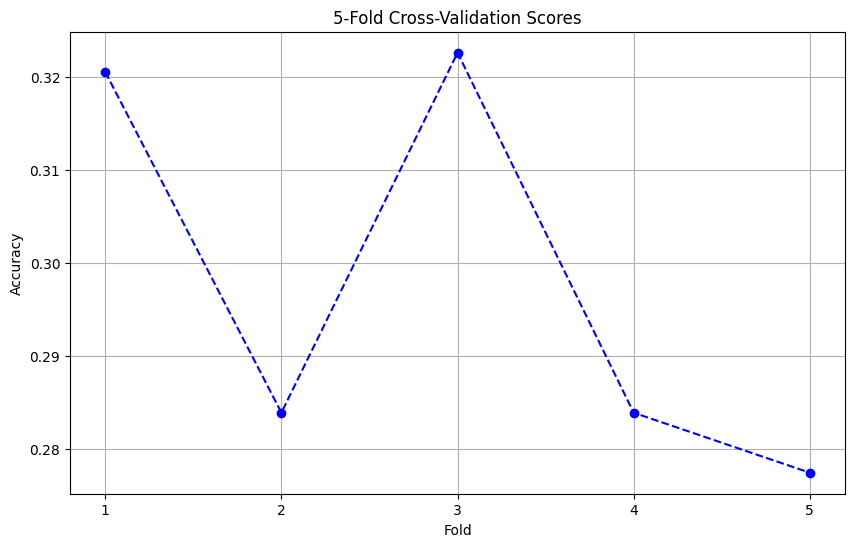

In [13]:
# Set the seed for all the models
seed = 7

# Print model score with 5 folds and plot the scores
xval_plot(word2vDesc, df.category)

### Weighted TF-IDF W2V

Fold score: 0.6089743589743589
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[20  8  2 10]
 [ 7 33  1  6]
 [ 3  3 29  2]
 [ 5  7  7 13]]

Precision: 0.5953579943143511
Recall: 0.598040360839563
F1-Score: 0.5956647571309225
-----------------------------------

Fold score: 0.6
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[17 20  4  3]
 [ 4 27  9  3]
 [ 2  3 35  1]
 [ 4  9  0 14]]

Precision: 0.6207725204017577
Recall: 0.5966119170529267
F1-Score: 0.594533797852105
-----------------------------------

Fold score: 0.5096774193548387
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[19  8  3  6]
 [11 29  2  6]
 [ 4  6 25  5]
 [10 11  4  6]]

Precision: 0.49125472542991727
Recall: 0.48762320788530467
F1-Score: 0.48538133721957255
-----------------------------------

Fold score: 0.5870967741935483
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[20  7  1  4]
 [ 7 27  5  5]
 [ 4  8 30  0]
 [12  8  3 14]]

Precision

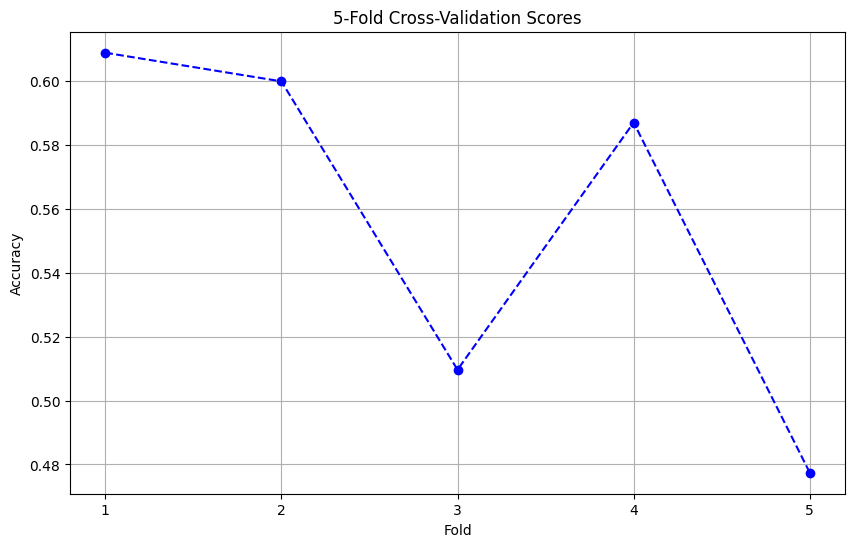

In [14]:
# get weighted embeddings for description
tfidf_docs_emb = compute_tfidf_weighted_embeddings(token_dict, word2v_wv, document_dict, corpus_bow)

# Print model score with 5 folds and plot the scores
xval_plot(tfidf_docs_emb, df.category)

## Description Summary: Weighted vs Non-Weighted
- Adding TF-IDF weights to the pre-processed description dramatically increases the accuracy of classifying a job post by about 30%.
- The non-weighted model showed heavy bias towards Engineering making it essentially useless. 

### Non-Weighted Title

Fold score: 0.3269230769230769
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 0 33  1  0]
 [ 0 45  1  0]
 [ 0 26  6  0]
 [ 0 41  3  0]]

Precision: 0.7139498432601881
Recall: 0.2914402173913043
F1-Score: 0.18756848898088396
-----------------------------------

Fold score: 0.33548387096774196
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 0 37  1  0]
 [ 0 48  1  0]
 [ 0 30  4  0]
 [ 0 31  3  0]]

Precision: 0.6933028919330289
Recall: 0.2743097238895558
F1-Score: 0.1695885509838998
-----------------------------------

Fold score: 0.3032258064516129
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 0 38  2  0]
 [ 0 46  1  0]
 [ 0 42  1  0]
 [ 0 24  1  0]]

Precision: 0.6266666666666667
Recall: 0.25049480455220186
F1-Score: 0.12716793570219967
-----------------------------------

Fold score: 0.2967741935483871
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 0 40  1  0]
 [ 0 40  4  0]
 [ 0 39  6  0]
 [ 0 24 

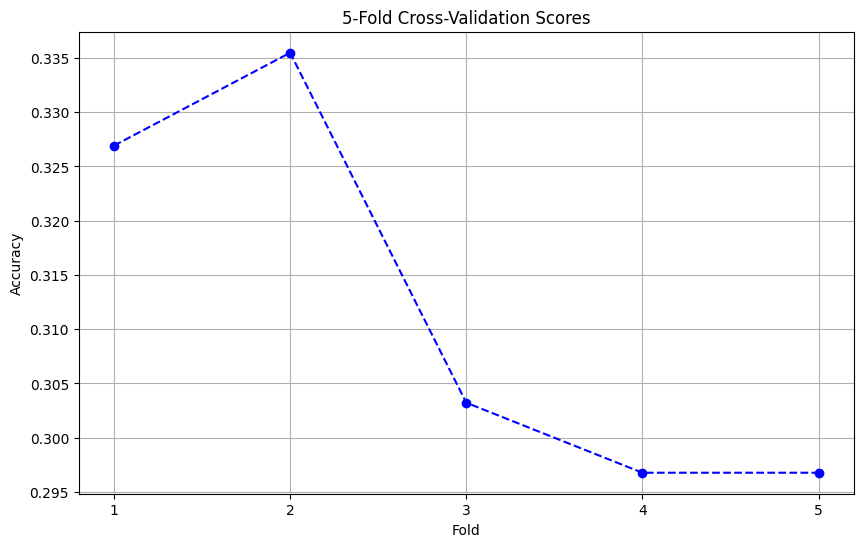

In [15]:
# Convert titles from ASCII to UTF-8
title_utf8 = [t.encode('ascii', 'ignore').decode('utf-8') for t in df.title]

# Tokenize the UTF-8 encoded titles
tokenized_title = [word_tokenize(text) for text in title_utf8]

# Convert the tokenized titles to vectors
title_vectors = docvecs(word2v_wv, tokenized_title)

# Print model score with 5 folds and plot the scores
xval_plot(title_vectors, df.category)


### Weighted Title

Fold score: 0.33974358974358976
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 2 38  1  0]
 [ 0 45  0  0]
 [ 0 30  6  0]
 [ 0 34  0  0]]

Precision: 0.7908163265306123
Recall: 0.3038617886178862
F1-Score: 0.2102107558139535
-----------------------------------

Fold score: 0.32903225806451614
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 2 34  2  0]
 [ 1 43  5  0]
 [ 0 25  6  0]
 [ 0 34  3  0]]

Precision: 0.5894607843137255
Recall: 0.2809327466130765
F1-Score: 0.20443624735269778
-----------------------------------

Fold score: 0.25806451612903225
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 0 40  4  0]
 [ 0 38  3  0]
 [ 0 41  2  0]
 [ 0 27  0  0]]

Precision: 0.6206240487062404
Recall: 0.24333522404991492
F1-Score: 0.12083504730563553
-----------------------------------

Fold score: 0.34838709677419355
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[ 0 26  4  0]
 [ 0 50  3  0]
 [ 0 42  4  0]
 [ 0 

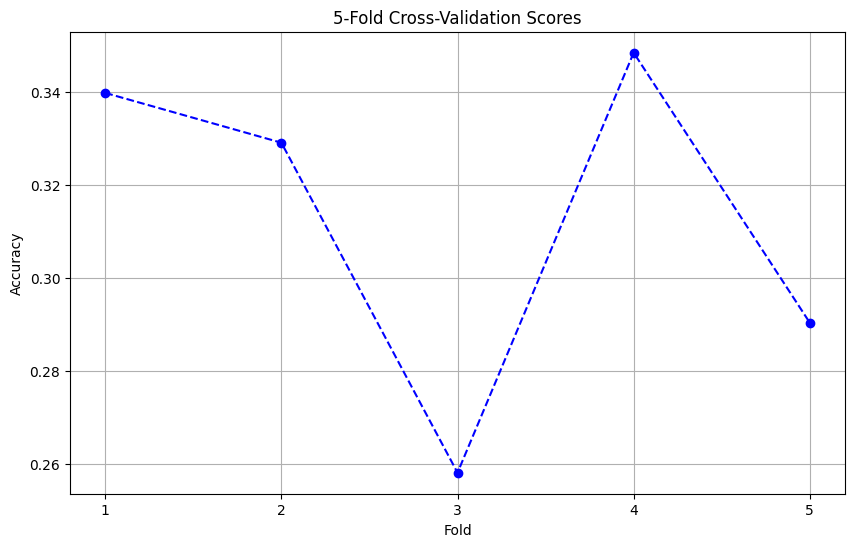

In [16]:
# Generate the TF-IDF representation
tfidf_title, title_dict, title_bow, title_token_dict = generate_tfidf_representation(tokenized_title)

# Compute the TF-IDF weighted embeddings
title_embed = compute_tfidf_weighted_embeddings(title_token_dict, word2v_wv, title_dict, title_bow)
xval_plot(title_embed, df.category)


## Title Summary: Weighted vs Non-Weighted
- Both weighted and non-weighted models showed heavy bias towards Engineering.
- Using the title to classify a job post is not a viable option here for the same reason as the non-weighted description model

### Non-Weighted Title & Description

Fold score: 0.6730769230769231
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[23  8  2  5]
 [ 6 30  1  7]
 [ 4  4 37  1]
 [ 7  4  2 15]]

Precision: 0.6609601449275362
Recall: 0.6567858628785401
F1-Score: 0.6582584082584082
-----------------------------------

Fold score: 0.7483870967741936
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[31  4  1  7]
 [ 2 33  2  1]
 [ 7  0 29  2]
 [ 5  5  3 23]]

Precision: 0.7500360750360751
Recall: 0.7478495172038624
F1-Score: 0.7476831672893316
-----------------------------------

Fold score: 0.8258064516129032
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[26  2  3  4]
 [ 3 50  3  3]
 [ 1  0 31  1]
 [ 6  1  0 21]]

Precision: 0.8068985543774092
Recall: 0.8199271773424316
F1-Score: 0.8119519750079424
-----------------------------------

Fold score: 0.7677419354838709
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[27  2  3  4]
 [ 4 42  0  2]
 [ 2  2 32  5]
 [ 7  4  1 1

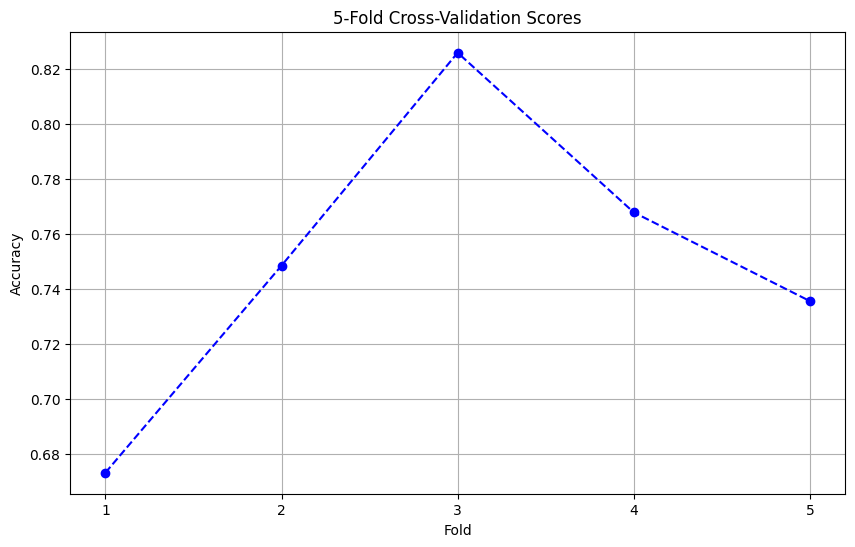

In [17]:
# Convert title+description from ASCII to UTF-8
tokenized_description = [word_tokenize(text) for text in df.description]
# Convert the tokenized titles to vectors
description_vectors = docvecs(word2v_wv, tokenized_description)
# Combine the title and description vectors via horizontal stacking
combined_features = np.hstack((title_vectors, description_vectors))
xval_plot(combined_features, df.category)

### Weighted Title & Description

Fold score: 0.5705128205128205
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[22  8  3  1]
 [11 32  2  4]
 [ 6  7 27  1]
 [ 8 15  1  8]]

Precision: 0.5934561320628582
Recall: 0.5521641583462653
F1-Score: 0.5493355674515095
-----------------------------------

Fold score: 0.5161290322580645
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[17  8  4  3]
 [ 9 25  6  8]
 [ 5  3 25  4]
 [ 8 13  4 13]]

Precision: 0.5128532182103611
Recall: 0.517466068041726
F1-Score: 0.511542821935973
-----------------------------------

Fold score: 0.49032258064516127
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[17 17  3  6]
 [13 22  7  1]
 [ 2  5 27  2]
 [ 7 11  5 10]]

Precision: 0.5012675920570657
Recall: 0.4900017618040874
F1-Score: 0.4851342037753188
-----------------------------------

Fold score: 0.6
['Accounting_Finance' 'Engineering' 'Healthcare_Nursing' 'Sales']
[[22 10  4  6]
 [ 5 30  2  7]
 [ 3  8 30  1]
 [ 5  9  2 11]]

Precision: 

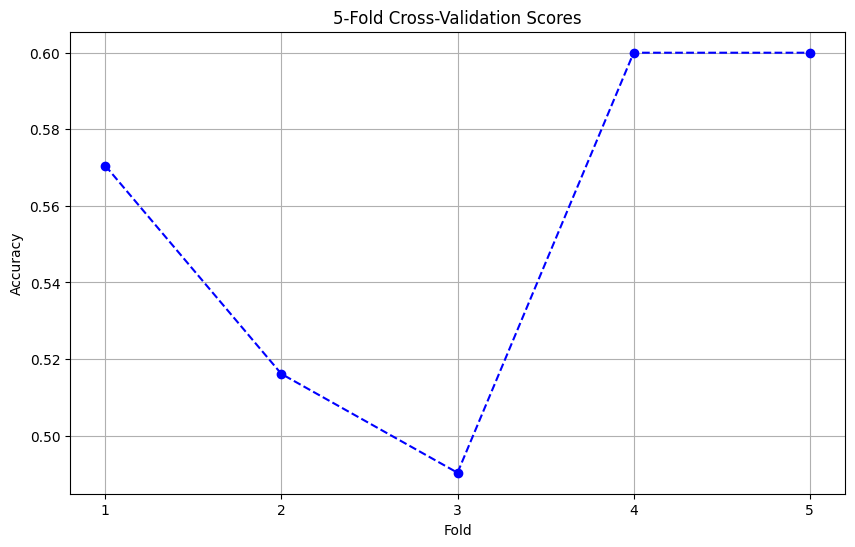

In [18]:
# Combine the title and description vectors via horizontal stacking
combined_features = np.hstack((title_embed, tfidf_docs_emb))
xval_plot(combined_features, df.category)


## Description & Title Summary: Weighted vs Non-Weighted
- Non-weighted model performed the best out of all of the models with the title
- With the added information (title), it improved the weighted model compared to the others, but introduced too much noise to perform as well as the non-weighted model.
- Both model had trouble classifying Sales. This might be because Accounting Finance is similar in terms of vocabulary and distinguishing context may be difficult.